In [49]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio as rio
from sklearn import svm
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np
from pyrsgis import raster
from pyrsgis import ml
import random
from copy import copy
from itertools import cycle
from osgeo import gdal
import tensorflow as tf
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns

In [48]:
featurefile = r'E:/Sentinel2/Sistan_Sentinel.tif'

In [3]:
lablefile = r'E:/Sentinel2/Sistan_Sentinel_Training.tif'

In [4]:
dsfeature , arrayfeature = raster.read(featurefile, bands = 'all')
arrayfeature = arrayfeature.astype(float)

In [5]:
print(arrayfeature)

[[[2112. 2070. 2056. ... 2527. 2510. 2522.]
  [2117. 2102. 2065. ... 2532. 2585. 2622.]
  [2125. 2125. 2116. ... 2545. 2543. 2592.]
  ...
  [1397. 1411. 1417. ... 2112. 2095. 2083.]
  [1454. 1442. 1470. ... 2085. 2096. 2086.]
  [1574. 1491. 1475. ... 2088. 2097. 2104.]]

 [[2308. 2288. 2270. ... 2888. 2868. 2850.]
  [2345. 2294. 2290. ... 2887. 2938. 2968.]
  [2352. 2349. 2333. ... 2915. 2913. 2962.]
  ...
  [1381. 1387. 1412. ... 2364. 2349. 2335.]
  [1437. 1456. 1471. ... 2357. 2343. 2342.]
  [1582. 1499. 1500. ... 2351. 2356. 2338.]]

 [[2745. 2711. 2721. ... 3568. 3536. 3547.]
  [2752. 2719. 2746. ... 3549. 3563. 3636.]
  [2796. 2756. 2762. ... 3549. 3587. 3665.]
  ...
  [1482. 1521. 1555. ... 2882. 2837. 2836.]
  [1582. 1607. 1599. ... 2869. 2869. 2847.]
  [1805. 1649. 1637. ... 2858. 2853. 2830.]]

 ...

 [[3002. 3002. 2976. ... 3866. 3931. 3931.]
  [3002. 3002. 2976. ... 3866. 3931. 3931.]
  [2941. 2941. 2920. ... 3919. 3909. 3909.]
  ...
  [1723. 1723. 1680. ... 3024. 3012. 301

In [6]:
arrayfeature.shape

(10, 866, 770)

In [7]:
for i in range(arrayfeature.shape[0]):
 minb = arrayfeature [i][:][:].min()
 maxb = arrayfeature [i][:][:].max()
 rangeb = maxb - minb
 for j in range(arrayfeature.shape[1]):
    for k in range(arrayfeature.shape[2]):
        arrayfeature[i][j][k] = (arrayfeature[i][j][k] - minb)/rangeb

In [8]:
print(arrayfeature)

[[[0.46893975 0.44932275 0.44278375 ... 0.6627744  0.65483419 0.66043905]
  [0.47127511 0.46426903 0.44698739 ... 0.66510976 0.68986455 0.70714619]
  [0.47501168 0.47501168 0.47080803 ... 0.67118169 0.67024755 0.69313405]
  ...
  [0.13498365 0.14152265 0.14432508 ... 0.46893975 0.46099953 0.45539468]
  [0.16160673 0.15600187 0.16907987 ... 0.45632882 0.4614666  0.45679589]
  [0.2176553  0.17888837 0.17141523 ... 0.45773003 0.46193368 0.46520318]]

 [[0.48655617 0.47918969 0.47255985 ... 0.70018416 0.69281768 0.68618785]
  [0.50018416 0.48139963 0.47992634 ... 0.69981584 0.71860037 0.72965009]
  [0.50276243 0.50165746 0.49576427 ... 0.71012891 0.70939227 0.72744015]
  ...
  [0.14511971 0.14732965 0.15653775 ... 0.50718232 0.50165746 0.49650092]
  [0.16574586 0.17274401 0.17826888 ... 0.50460405 0.49944751 0.49907919]
  [0.21915285 0.18858195 0.18895028 ... 0.50239411 0.50423573 0.49760589]]

 [[0.49627721 0.48654066 0.48940435 ... 0.73195876 0.72279496 0.72594502]
  [0.49828179 0.488831

In [9]:
print (arrayfeature.shape)

(10, 866, 770)


In [10]:
features = ml.array_to_chips(arrayfeature, y_size=7, x_size=7)

In [11]:
features.shape

(666820, 7, 7, 10)

In [12]:
dslable, arraylable = raster.read(lablefile)

In [13]:
np.unique(arraylable)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9, 255], dtype=uint8)

In [14]:
arraylable[arraylable==255]=0

In [15]:
np.unique(arraylable)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [16]:
arraylable = arraylable.flatten()

In [17]:
arraylable.shape

(666820,)

In [18]:
features = features[arraylable != 0]
lable = arraylable[arraylable != 0]

In [19]:
np.unique(lable)

array([1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [20]:
slin = int(features.shape[0] * 0.70)

In [21]:
slin

27069

In [22]:
def train_test_split(features, lable, trainprob = 0.70):
    datasize = features.shape[0]
    sliceindex = int(datasize * trainprob)
    randindex = np.arange(datasize)
    random.shuffle(randindex)
    train_x = features[[randindex[:sliceindex]],:,:,:][0]
    test_x = features[[randindex[sliceindex:]],:,:,:][0]
    train_y = lable[randindex[:sliceindex]]
    test_y = lable[randindex[sliceindex:]]
    return(train_x, train_y, test_x, test_y)

In [23]:
train_x, train_y, test_x, test_y = train_test_split(features, lable)

In [24]:
print(train_x)
print(train_y)
print(test_x)
print(test_y)

[[[[0.13218122 0.14217311 0.14662085 ... 0.10995851 0.19201264
    0.22428149]
   [0.12891172 0.1373849  0.1489118  ... 0.16567872 0.23984657
    0.28686543]
   [0.15973844 0.18379374 0.19243986 ... 0.16567872 0.23984657
    0.28686543]
   ...
   [0.20924801 0.22983425 0.24799542 ... 0.23058684 0.31565884
    0.37335482]
   [0.20177487 0.21473297 0.22623139 ... 0.22080616 0.32829422
    0.38248724]
   [0.20411023 0.22467772 0.22966781 ... 0.22080616 0.32829422
    0.38248724]]

  [[0.15506773 0.16316759 0.16093929 ... 0.10995851 0.19201264
    0.22428149]
   [0.14712751 0.16353591 0.16953036 ... 0.16567872 0.23984657
    0.28686543]
   [0.17048108 0.19705341 0.20704467 ... 0.16567872 0.23984657
    0.28686543]
   ...
   [0.21578702 0.2412523  0.26174112 ... 0.23058684 0.31565884
    0.37335482]
   [0.21672116 0.22909761 0.24255441 ... 0.22080616 0.32829422
    0.38248724]
   [0.21858944 0.23535912 0.25171821 ... 0.22080616 0.32829422
    0.38248724]]

  [[0.15833723 0.1786372  0.176689

In [25]:
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(27069, 7, 7, 10)
(27069,)
(11602, 7, 7, 10)
(11602,)


In [26]:
model =  tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(32, kernel_size = 1, padding = 'valid', activation = 'relu',
                                 input_shape = (train_x.shape[1], train_x.shape[2], train_x.shape[3])))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Conv2D(48, kernel_size = 1, padding = 'valid', activation = 'relu'))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(64, activation = 'relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(10, activation = 'softmax'))
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 7, 7, 32)          352       
                                                                 
 dropout (Dropout)           (None, 7, 7, 32)          0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 48)          1584      
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 48)          0         
                                                                 
 flatten (Flatten)           (None, 2352)              0         
                                                                 
 dense (Dense)               (None, 64)                150592    
                                                                 
 dropout_2 (Dropout)         (None, 64)                0

In [27]:
model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'rmsprop', metrics = ['accuracy'])
model.fit(train_x, train_y, epochs =20)

Epoch 1/20
846/846 [==============================] - 9s 6ms/step - loss: 0.7627 - accuracy: 0.7552
Epoch 2/20
846/846 [==============================] - 5s 5ms/step - loss: 0.4790 - accuracy: 0.8304
Epoch 3/20
846/846 [==============================] - 5s 6ms/step - loss: 0.3729 - accuracy: 0.8729
Epoch 4/20
846/846 [==============================] - 5s 6ms/step - loss: 0.3011 - accuracy: 0.8966
Epoch 5/20
846/846 [==============================] - 5s 5ms/step - loss: 0.2703 - accuracy: 0.9089
Epoch 6/20
846/846 [==============================] - 5s 5ms/step - loss: 0.2471 - accuracy: 0.9153
Epoch 7/20
846/846 [==============================] - 5s 5ms/step - loss: 0.2267 - accuracy: 0.9230
Epoch 8/20
846/846 [==============================] - 5s 5ms/step - loss: 0.2128 - accuracy: 0.9293
Epoch 9/20
846/846 [==============================] - 5s 5ms/step - loss: 0.2019 - accuracy: 0.9336
Epoch 10/20
846/846 [==============================] - 5s 6ms/step - loss: 0.1894 - accuracy: 0.9371

In [28]:
dspre , featurepre = raster.read(r'E:/Sentinel2/Sistan_Sentinel.tif')
featurepre = featurepre.astype(float)

In [29]:
for i in range(featurepre.shape[0]):
 minb = featurepre [i][:][:].min()
 maxb = featurepre [i][:][:].max()
 rangeb = maxb - minb
 for j in range(featurepre.shape[1]):
    for k in range(featurepre.shape[2]):
        featurepre[i][j][k] = (featurepre[i][j][k] - minb)/rangeb

In [30]:
new_features = ml.array_to_chips(featurepre, x_size = 7, y_size = 7)

In [31]:
newpredicted = model.predict(new_features)

20839/20839 [==============================] - 51s 2ms/step


In [32]:
prediction = np.reshape(newpredicted.argmax(axis = 1), (dspre.RasterYSize, dspre.RasterXSize))

In [33]:
prediction.shape

(866, 770)

In [34]:
outfile = r'E:/Sentinel2/CNN.tif'
raster. export(prediction, dspre, filename = outfile, dtype = 'float')

In [35]:
cnn_map = prediction
print(cnn_map.shape)

(866, 770)


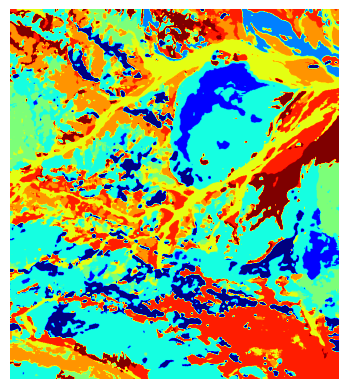

In [36]:
plt.figure()
plt.imshow(cnn_map, cmap = 'jet')
plt.axis('off')
plt.show()

In [39]:
yTestPredicted = model.predict(test_x)

363/363 [==============================] - 1s 2ms/step


In [40]:
y_score = yTestPredicted[:, 1:yTestPredicted.shape[1]]

In [41]:
yTestPredicted

array([[1.9524287e-04, 7.3698434e-06, 5.5622915e-03, ..., 6.2271133e-03,
        2.1779741e-07, 9.6206536e-04],
       [4.6655840e-10, 8.8622068e-13, 3.8531212e-07, ..., 1.2244982e-12,
        2.3187082e-16, 7.0556561e-09],
       [2.8325897e-22, 1.0000000e+00, 2.1054602e-29, ..., 0.0000000e+00,
        3.5064366e-23, 0.0000000e+00],
       ...,
       [1.3533373e-05, 6.7665377e-07, 1.4333658e-02, ..., 4.1812056e-04,
        7.9229255e-11, 8.3435161e-06],
       [3.4456695e-29, 1.3235304e-25, 1.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [5.5740287e-07, 1.8889406e-07, 1.4588804e-04, ..., 7.5314034e-07,
        1.3079166e-13, 5.5402715e-08]], dtype=float32)

In [42]:
yTestPredicted = (yTestPredicted > 0.5).astype(int)

In [43]:
cMatrix =  confusion_matrix(test_y, yTestPredicted.argmax(axis=1))
pScore = precision_score(test_y, yTestPredicted.argmax(axis=1), average = 'micro')
rScore = recall_score(test_y, yTestPredicted.argmax(axis=1), average = 'micro')
fScore = f1_score(test_y, yTestPredicted.argmax(axis=1), average = 'micro')

In [44]:
print("Confusion Matrix:\n", cMatrix)

Confusion Matrix:
 [[   0    0    0    0    0    0    0    0    0    0]
 [   0  669    0    0    3    0    0    0    1    0]
 [   0    0 1445    0   14    0    0    0    0    0]
 [   0    0    0  269    0    0    0    0    2    0]
 [   6    0   10    0 3316   32    0    0    0    0]
 [  33    0   16    0  108 3236   41    0    0    0]
 [   7    1    0    4    1    3 1205    0   16    0]
 [   7    0    0    0    0    0    0  664    2    2]
 [   0    0    0    0    0    0    0    0  182    0]
 [   0    0    0    0   16    0    0    0    1  290]]


In [46]:
print("\nP-Score: %.3f, R-Score: %.3f, F-Score: %.3f" % (pScore, rScore, fScore))


P-Score: 0.972, R-Score: 0.972, F-Score: 0.972


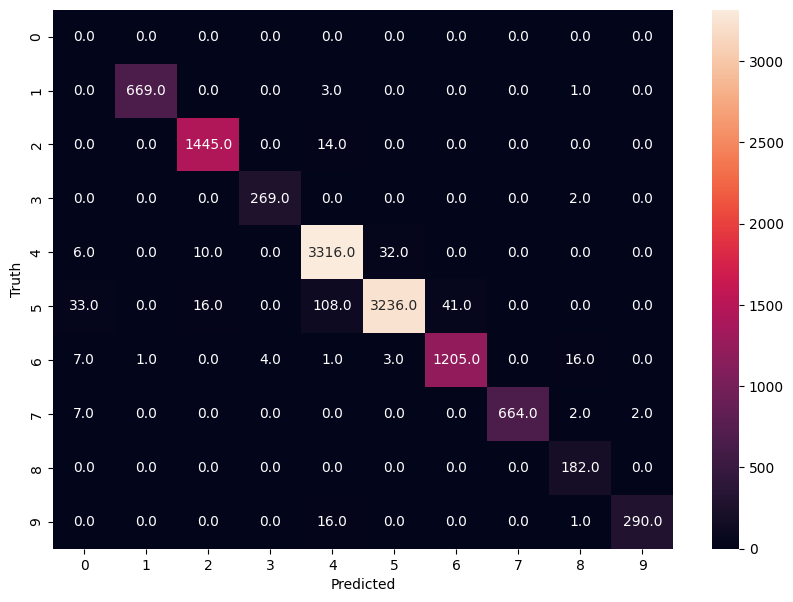

In [50]:
plt.figure(figsize=(10,7))
sns.heatmap(cMatrix, annot = True, fmt = ".1f")
plt.xlabel("Predicted")
plt.ylabel("Truth")
plt.show()